# RecoMart Data Preparation and Exploratory Data Analysis

**Assignment**: Data Management for Machine Learning - Task 5: Data Preparation

**Objective**: Perform comprehensive data cleaning, preprocessing, and exploratory analysis for the RecoMart recommendation system pipeline.

**Deliverables**:
- Data cleaning and preprocessing (missing values, encoding, normalization)
- Exploratory analysis showing interaction distributions, item popularity, and sparsity patterns
- Summary plots (histograms, heatmaps)
- Prepared dataset ready for transformation

---

## 1. Import Required Libraries

Import necessary libraries for data manipulation, visualization, and preprocessing.

In [3]:
# Core data manipulation and analysis libraries
import pandas as pd
import numpy as np
from pathlib import Path
import json
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and machine learning libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from scipy import stats
from scipy.sparse import csr_matrix

# Set plotting styles
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

Libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 2.4.1
Matplotlib version: 3.10.8
Seaborn version: 0.13.2


## 2. Load Raw Data

Load user interaction data, product metadata, and other datasets from our validated data pipeline.

In [4]:
# Define data paths
raw_data_path = Path("../data/raw")

def discover_latest_files():
    """Discover the latest data files from our partitioned storage structure."""
    data_files = {}
    
    # CSV ingestion data
    csv_path = raw_data_path / "source=csv_ingestion"
    if csv_path.exists():
        for type_dir in csv_path.iterdir():
            if type_dir.is_dir() and type_dir.name.startswith("type="):
                data_type = type_dir.name.replace("type=", "")
                latest_file = None
                latest_timestamp = None
                
                for timestamp_dir in type_dir.iterdir():
                    if timestamp_dir.is_dir():
                        for file in timestamp_dir.iterdir():
                            if file.suffix == '.parquet':
                                if latest_timestamp is None or timestamp_dir.name > latest_timestamp:
                                    latest_timestamp = timestamp_dir.name
                                    latest_file = file
                
                if latest_file:
                    data_files[f"csv_{data_type}"] = latest_file
    
    # API ingestion data
    api_path = raw_data_path / "source=api_ingestion"
    if api_path.exists():
        for type_dir in api_path.iterdir():
            if type_dir.is_dir() and type_dir.name.startswith("type="):
                data_type = type_dir.name.replace("type=", "")
                latest_file = None
                latest_timestamp = None
                
                for timestamp_dir in type_dir.iterdir():
                    if timestamp_dir.is_dir():
                        for file in timestamp_dir.iterdir():
                            if file.suffix == '.parquet':
                                if latest_timestamp is None or timestamp_dir.name > latest_timestamp:
                                    latest_timestamp = timestamp_dir.name
                                    latest_file = file
                
                if latest_file:
                    data_files[f"api_{data_type}"] = latest_file
    
    return data_files

# Discover available data files
data_files = discover_latest_files()
print("Available data files:")
for name, path in data_files.items():
    print(f"  {name}: {path}")
print()

Available data files:
  csv_item_properties: ../data/raw/source=csv_ingestion/type=item_properties/timestamp=20260126_141918/item_properties_csv_ingestion_20260126_141918.parquet
  csv_events: ../data/raw/source=csv_ingestion/type=events/timestamp=20260126_141844/events_csv_ingestion_20260126_141844.parquet
  api_products: ../data/raw/source=api_ingestion/type=products/timestamp=20260126_141937/products_api_ingestion_20260126_141937.parquet
  api_categories: ../data/raw/source=api_ingestion/type=categories/timestamp=20260126_141938/categories_api_ingestion_20260126_141938.parquet



In [5]:
# Load datasets
datasets = {}

for name, file_path in data_files.items():
    try:
        print(f"Loading {name} from {file_path.name}...")
        df = pd.read_parquet(file_path)
        datasets[name] = df
        print(f"  Shape: {df.shape}")
        print(f"  Columns: {list(df.columns)}")
        print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")
        print()
    except Exception as e:
        print(f"  Error loading {name}: {e}")
        print()

print(f"Successfully loaded {len(datasets)} datasets")
print("Dataset summary:")
for name, df in datasets.items():
    print(f"  {name}: {df.shape[0]:,} rows × {df.shape[1]} columns")

Loading csv_item_properties from item_properties_csv_ingestion_20260126_141918.parquet...
  Shape: (12003814, 7)
  Columns: ['timestamp', 'itemid', 'property', 'value', 'ingestion_timestamp', 'ingestion_source', 'ingestion_batch_id']
  Memory usage: 3180.19 MB

Loading csv_events from events_csv_ingestion_20260126_141844.parquet...
  Shape: (2755641, 8)
  Columns: ['timestamp', 'visitorid', 'event', 'itemid', 'transactionid', 'ingestion_timestamp', 'ingestion_source', 'ingestion_batch_id']
  Memory usage: 586.52 MB

Loading api_products from products_api_ingestion_20260126_141937.parquet...
  Shape: (100, 26)
  Columns: ['id', 'title', 'description', 'category', 'price', 'discountPercentage', 'rating', 'stock', 'tags', 'brand', 'sku', 'weight', 'dimensions', 'warrantyInformation', 'shippingInformation', 'availabilityStatus', 'reviews', 'returnPolicy', 'minimumOrderQuantity', 'meta', 'images', 'thumbnail', 'ingested_at', 'data_source', 'primary_image', 'image_count']
  Memory usage: 0.1

## 3. Data Cleaning and Preprocessing

Perform initial data cleaning including removing duplicates, handling data type conversions, and identifying data quality issues.

In [7]:
# Data quality assessment function
def assess_data_quality(df, dataset_name):
    """Assess the data quality of a given dataset."""
    print(f"=== Data Quality Assessment: {dataset_name} ===")
    print(f"Shape: {df.shape}")
    print(f"Data types:")
    print(df.dtypes)
    print(f"\nMissing values:")
    missing_counts = df.isnull().sum()
    missing_pct = (missing_counts / len(df) * 100).round(2)
    missing_info = pd.DataFrame({
        'Missing Count': missing_counts,
        'Missing %': missing_pct
    })
    print(missing_info[missing_info['Missing Count'] > 0])
    
    # Safe duplicate checking - handle unhashable types
    try:
        duplicate_count = df.duplicated().sum()
        print(f"\nDuplicate rows: {duplicate_count}")
    except TypeError as e:
        print(f"\nDuplicate check failed (complex data types): {str(e)}")
        # Alternative: check duplicates on string representation
        try:
            df_str = df.astype(str)
            duplicate_count = df_str.duplicated().sum()
            print(f"Approximate duplicates (string-based): {duplicate_count}")
        except Exception:
            print("Unable to perform duplicate check on this dataset")
    
    # Examine first few rows
    print(f"\nFirst 3 rows:")
    print(df.head(3))
    print("-" * 80)

# Assess data quality for each dataset
for name, df in datasets.items():
    assess_data_quality(df, name)

=== Data Quality Assessment: csv_item_properties ===
Shape: (12003814, 7)
Data types:
timestamp                       int64
itemid                          int64
property                       object
value                          object
ingestion_timestamp    datetime64[us]
ingestion_source               object
ingestion_batch_id             object
dtype: object

Missing values:
Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []

Duplicate rows: 0

First 3 rows:
       timestamp  itemid    property    value        ingestion_timestamp  \
0  1435460400000  460429  categoryid     1338 2026-01-26 14:19:15.776551   
1  1431831600000  156781         917   828513 2026-01-26 14:19:15.776551   
2  1434250800000   89534         213  1121373 2026-01-26 14:19:15.776551   

      ingestion_source     ingestion_batch_id  
0  csv_item_properties  items_20260126_141915  
1  csv_item_properties  items_20260126_141915  
2  csv_item_properties  items_20260126_141915  
------------------------

In [9]:
# Clean and prepare individual datasets
cleaned_datasets = {}

# Clean Events Data (User-Item Interactions)
if 'csv_events' in datasets:
    print("=== Cleaning Events Data ===")
    events_df = datasets['csv_events'].copy()
    
    # Remove ingestion metadata columns for analysis
    analysis_columns = ['timestamp', 'visitorid', 'event', 'itemid', 'transactionid']
    events_clean = events_df[analysis_columns].copy()
    
    # Safe timestamp conversion with error handling
    print(f"Timestamp range: {events_clean['timestamp'].min()} to {events_clean['timestamp'].max()}")
    print(f"Sample timestamp values: {events_clean['timestamp'].head().tolist()}")
    
    # Convert timestamp to datetime with bounds checking
    try:
        # First, check if timestamps are reasonable (between 1970 and 2050)
        min_valid_timestamp = 0  # 1970-01-01
        max_valid_timestamp = 2524608000  # 2050-01-01 (approximately)
        
        # Filter out invalid timestamps
        valid_timestamps = (
            (events_clean['timestamp'] >= min_valid_timestamp) & 
            (events_clean['timestamp'] <= max_valid_timestamp) &
            events_clean['timestamp'].notna()
        )
        
        print(f"Valid timestamps: {valid_timestamps.sum()} out of {len(events_clean)} ({valid_timestamps.sum()/len(events_clean)*100:.1f}%)")
        
        if valid_timestamps.sum() > 0:
            # Create datetime column with NaT for invalid timestamps
            events_clean['datetime'] = pd.NaT
            events_clean.loc[valid_timestamps, 'datetime'] = pd.to_datetime(
                events_clean.loc[valid_timestamps, 'timestamp'], 
                unit='s', 
                errors='coerce'
            )
            
            # Report on conversion results
            successful_conversions = events_clean['datetime'].notna().sum()
            print(f"Successfully converted {successful_conversions} timestamps to datetime")
            
            if successful_conversions < len(events_clean):
                print(f"Warning: {len(events_clean) - successful_conversions} timestamps could not be converted")
        else:
            print("No valid timestamps found - creating placeholder datetime column")
            events_clean['datetime'] = pd.NaT
            
    except Exception as e:
        print(f"Timestamp conversion failed: {e}")
        print("Creating placeholder datetime column with current timestamp")
        events_clean['datetime'] = pd.Timestamp.now()
    
    # Remove rows with missing critical information
    print(f"Original shape: {events_clean.shape}")
    events_clean = events_clean.dropna(subset=['visitorid', 'itemid', 'event'])
    print(f"After removing missing critical values: {events_clean.shape}")
    
    # Remove duplicates
    events_clean = events_clean.drop_duplicates()
    print(f"After removing duplicates: {events_clean.shape}")
    
    cleaned_datasets['events'] = events_clean
    print(f"Events data cleaned. Final shape: {events_clean.shape}")
    print()

# Clean Item Properties Data  
if 'csv_item_properties' in datasets:
    print("=== Cleaning Item Properties Data ===")
    props_df = datasets['csv_item_properties'].copy()
    
    # Remove ingestion metadata columns
    analysis_columns = ['timestamp', 'itemid', 'property', 'value']
    props_clean = props_df[analysis_columns].copy()
    
    # Remove missing values
    print(f"Original shape: {props_clean.shape}")
    props_clean = props_clean.dropna()
    print(f"After removing missing values: {props_clean.shape}")
    
    # Remove duplicates
    props_clean = props_clean.drop_duplicates()
    print(f"After removing duplicates: {props_clean.shape}")
    
    cleaned_datasets['item_properties'] = props_clean
    print(f"Item properties data cleaned. Final shape: {props_clean.shape}")
    print()

print(f"Cleaned datasets: {list(cleaned_datasets.keys())}")

=== Cleaning Events Data ===
Timestamp range: 1430622004384 to 1442545187788
Sample timestamp values: [1433221332117, 1433224214164, 1433221999827, 1433221955914, 1433221337106]
Valid timestamps: 0 out of 2755641 (0.0%)
No valid timestamps found - creating placeholder datetime column
Original shape: (2755641, 6)
After removing missing critical values: (2755641, 6)
After removing duplicates: (2755641, 6)
Events data cleaned. Final shape: (2755641, 6)

=== Cleaning Item Properties Data ===
Original shape: (12003814, 4)
After removing missing values: (12003814, 4)
After removing duplicates: (12003814, 4)
Item properties data cleaned. Final shape: (12003814, 4)

Cleaned datasets: ['events', 'item_properties']


## 4. Handle Missing User-Item Interactions

Implement strategies to handle missing values in user-item interaction data, including imputation methods and removal of incomplete records based on business logic.

In [10]:
# Handle missing interactions in events data
if 'events' in cleaned_datasets:
    events_df = cleaned_datasets['events'].copy()
    
    print("=== Handling Missing User-Item Interactions ===")
    print("Missing value analysis:")
    missing_analysis = events_df.isnull().sum()
    print(missing_analysis)
    
    # Handle missing transaction IDs (business logic: most events don't have transactions)
    if 'transactionid' in events_df.columns:
        transaction_missing = events_df['transactionid'].isnull().sum()
        transaction_events = events_df[events_df['event'] == 'transaction']['transactionid'].isnull().sum()
        
        print(f"\nTransaction ID missing: {transaction_missing:,} out of {len(events_df):,} ({transaction_missing/len(events_df)*100:.1f}%)")
        print(f"Missing transaction IDs in transaction events: {transaction_events}")
        
        # For transaction events, remove rows with missing transaction IDs
        # For other events, transaction ID should be null - this is expected behavior
        before_shape = events_df.shape[0]
        events_df = events_df[~((events_df['event'] == 'transaction') & events_df['transactionid'].isnull())]
        after_shape = events_df.shape[0]
        print(f"Removed {before_shape - after_shape} incomplete transaction records")
    
    # Create implicit ratings based on event types
    # This handles the implicit nature of user-item interactions
    event_weights = {
        'view': 1,
        'addtocart': 2, 
        'transaction': 3
    }
    
    events_df['implicit_rating'] = events_df['event'].map(event_weights)
    
    # Remove any remaining rows with missing critical information
    critical_columns = ['visitorid', 'itemid', 'event']
    before_shape = events_df.shape[0]
    events_df = events_df.dropna(subset=critical_columns)
    after_shape = events_df.shape[0]
    print(f"Removed {before_shape - after_shape} rows with missing critical interaction data")
    
    # Update cleaned dataset
    cleaned_datasets['events'] = events_df
    
    print(f"\nFinal events dataset shape: {events_df.shape}")
    print("Event distribution after cleaning:")
    print(events_df['event'].value_counts())

=== Handling Missing User-Item Interactions ===
Missing value analysis:
timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733184
datetime         2755641
dtype: int64

Transaction ID missing: 2,733,184 out of 2,755,641 (99.2%)
Missing transaction IDs in transaction events: 0
Removed 0 incomplete transaction records
Removed 0 rows with missing critical interaction data

Final events dataset shape: (2755641, 7)
Event distribution after cleaning:
event
view           2664218
addtocart        68966
transaction      22457
Name: count, dtype: int64


## 5. Encode Categorical Attributes

Apply encoding techniques to categorical variables such as product categories, user demographics, and other categorical features.

In [11]:
# Encode categorical variables
print("=== Encoding Categorical Attributes ===")

# Encode event types in events data
if 'events' in cleaned_datasets:
    events_df = cleaned_datasets['events'].copy()
    
    # Label encode event types
    le_event = LabelEncoder()
    events_df['event_encoded'] = le_event.fit_transform(events_df['event'])
    
    print("Event encoding mapping:")
    for i, event in enumerate(le_event.classes_):
        print(f"  {event}: {i}")
    
    # Create one-hot encoding for events (useful for some ML models)
    event_dummies = pd.get_dummies(events_df['event'], prefix='event')
    events_df = pd.concat([events_df, event_dummies], axis=1)
    
    cleaned_datasets['events'] = events_df
    print(f"Added encoded event columns to events data")
    print()

# Process item properties for categorical encoding
if 'item_properties' in cleaned_datasets:
    props_df = cleaned_datasets['item_properties'].copy()
    
    print("=== Item Properties Categorical Encoding ===")
    print("Property types and their frequencies:")
    print(props_df['property'].value_counts())
    print()
    
    # Create a pivot table to get item features
    # This transforms property-value pairs into columnar format
    item_features = props_df.pivot_table(
        index='itemid',
        columns='property', 
        values='value',
        aggfunc='first'  # Take first value if multiple entries
    ).reset_index()
    
    print(f"Created item features matrix: {item_features.shape}")
    print("Available features:", item_features.columns.tolist())
    
    # Handle categorical columns in item features
    categorical_columns = []
    for col in item_features.columns:
        if col != 'itemid' and item_features[col].dtype == 'object':
            categorical_columns.append(col)
    
    print(f"Categorical feature columns: {categorical_columns}")
    
    # Label encode categorical features
    encoders = {}
    for col in categorical_columns:
        if col in item_features.columns:
            # Fill missing values with 'unknown'
            item_features[col] = item_features[col].fillna('unknown')
            
            # Label encode
            le = LabelEncoder()
            item_features[f'{col}_encoded'] = le.fit_transform(item_features[col].astype(str))
            encoders[col] = le
            
            print(f"Encoded {col}: {len(le.classes_)} unique values")
    
    cleaned_datasets['item_features'] = item_features
    cleaned_datasets['categorical_encoders'] = encoders
    print(f"Created item features dataset: {item_features.shape}")
    print()

=== Encoding Categorical Attributes ===
Event encoding mapping:
  addtocart: 0
  transaction: 1
  view: 2
Added encoded event columns to events data

=== Item Properties Categorical Encoding ===
Property types and their frequencies:
property
categoryid    417053
790           417053
364           417053
888           417053
112           417053
               ...  
782                1
288                1
722                1
744                1
769                1
Name: count, Length: 1104, dtype: int64

Created item features matrix: (417053, 1105)
Available features: ['itemid', '0', '1', '10', '100', '1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '101', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '102', '1020', '1021', '1022', '1023', '1024', '1025', '1026', '1027', '1028', '1029', '103', '1030', '1031', '1032', '1033', '1034', '1035', '1036', '1037', '1038', '1039', '104', '1040', '1041', '1042', '1043', '1044',

## 6. Normalize Numerical Variables

Normalize and scale numerical variables including prices, timestamps, ratings, and other continuous features using StandardScaler and MinMaxScaler.

In [13]:
# Normalize numerical variables
print("=== Normalizing Numerical Variables ===")
scalers = {}

# Normalize timestamp and other numerical features in events data
if 'events' in cleaned_datasets:
    events_df = cleaned_datasets['events'].copy()
    
    # Normalize timestamps (convert to relative time from min timestamp)
    if 'timestamp' in events_df.columns:
        # Only use valid timestamps for normalization
        valid_timestamps = events_df['timestamp'].dropna()
        
        if len(valid_timestamps) > 0:
            min_timestamp = valid_timestamps.min()
            max_timestamp = valid_timestamps.max()
            
            # Create normalized timestamp (0-1 range) only for valid timestamps
            if max_timestamp > min_timestamp:
                events_df['timestamp_normalized'] = (events_df['timestamp'] - min_timestamp) / (max_timestamp - min_timestamp)
            else:
                events_df['timestamp_normalized'] = 0  # All timestamps are the same
            
            # Create time-based features from valid datetime entries
            if events_df['datetime'].notna().any():
                valid_datetime_mask = events_df['datetime'].notna()
                events_df['hour'] = np.nan
                events_df['day_of_week'] = np.nan
                events_df['day_of_month'] = np.nan
                
                events_df.loc[valid_datetime_mask, 'hour'] = events_df.loc[valid_datetime_mask, 'datetime'].dt.hour
                events_df.loc[valid_datetime_mask, 'day_of_week'] = events_df.loc[valid_datetime_mask, 'datetime'].dt.dayofweek
                events_df.loc[valid_datetime_mask, 'day_of_month'] = events_df.loc[valid_datetime_mask, 'datetime'].dt.day
                
                print(f"Timestamp normalization complete. Range: {min_timestamp} - {max_timestamp}")
                print(f"Time-based features created for {valid_datetime_mask.sum()} valid datetime entries")
            else:
                print(f"Timestamp normalization complete but no valid datetime features created")
                events_df['hour'] = 12  # Default to noon
                events_df['day_of_week'] = 0  # Default to Monday
                events_df['day_of_month'] = 15  # Default to mid-month
        else:
            print("No valid timestamps found for normalization")
            events_df['timestamp_normalized'] = 0
            events_df['hour'] = 12
            events_df['day_of_week'] = 0 
            events_df['day_of_month'] = 15
    
    # Normalize implicit ratings
    if 'implicit_rating' in events_df.columns:
        scaler_rating = StandardScaler()
        events_df['implicit_rating_scaled'] = scaler_rating.fit_transform(events_df[['implicit_rating']])
        scalers['implicit_rating'] = scaler_rating
        print("Normalized implicit ratings using StandardScaler")
    
    # Normalize user and item IDs for consistency
    scaler_user = StandardScaler()
    scaler_item = StandardScaler()
    
    events_df['visitorid_scaled'] = scaler_user.fit_transform(events_df[['visitorid']])
    events_df['itemid_scaled'] = scaler_item.fit_transform(events_df[['itemid']])
    
    scalers['visitorid'] = scaler_user
    scalers['itemid'] = scaler_item
    
    cleaned_datasets['events'] = events_df
    print("Normalized user and item IDs using StandardScaler")

# Normalize numerical features in item properties
if 'item_features' in cleaned_datasets:
    features_df = cleaned_datasets['item_features'].copy()
    
    # Identify numerical columns
    numerical_columns = []
    for col in features_df.columns:
        if col != 'itemid' and features_df[col].dtype in ['int64', 'float64']:
            # Check if it's not already an encoded categorical
            if not col.endswith('_encoded'):
                numerical_columns.append(col)
    
    print(f"Found numerical columns in item features: {numerical_columns}")
    
    # Normalize numerical features
    for col in numerical_columns:
        # Handle missing values first
        median_val = features_df[col].median()
        features_df[col] = features_df[col].fillna(median_val)
        
        # Apply MinMax scaling for item features (keeps values in [0,1] range)
        scaler = MinMaxScaler()
        features_df[f'{col}_normalized'] = scaler.fit_transform(features_df[[col]])
        scalers[f'item_{col}'] = scaler
        
        print(f"Normalized {col} using MinMaxScaler")
    
    cleaned_datasets['item_features'] = features_df

# Store scalers for future use
cleaned_datasets['scalers'] = scalers

print(f"\nNormalization complete. Saved {len(scalers)} scalers for future use.")
print("Available scalers:", list(scalers.keys()))

=== Normalizing Numerical Variables ===
Timestamp normalization complete but no valid datetime features created
Normalized implicit ratings using StandardScaler
Normalized user and item IDs using StandardScaler
Found numerical columns in item features: []

Normalization complete. Saved 3 scalers for future use.
Available scalers: ['implicit_rating', 'visitorid', 'itemid']


## 7. Exploratory Data Analysis

Conduct comprehensive EDA to understand data distributions, correlations, and patterns in the cleaned dataset using descriptive statistics and visualizations.

In [15]:
# Comprehensive EDA
print("=== Exploratory Data Analysis Overview ===")

if 'events' in cleaned_datasets:
    events_df = cleaned_datasets['events']
    
    print("Events Dataset Summary:")
    print(f"  Total interactions: {len(events_df):,}")
    print(f"  Unique users: {events_df['visitorid'].nunique():,}")
    print(f"  Unique items: {events_df['itemid'].nunique():,}")
    
    # Safe datetime display
    if events_df['datetime'].notna().any():
        valid_datetimes = events_df['datetime'].dropna()
        print(f"  Date range: {valid_datetimes.min()} to {valid_datetimes.max()}")
        if len(valid_datetimes) > 1:
            print(f"  Time span: {(valid_datetimes.max() - valid_datetimes.min()).days} days")
        print(f"  Valid datetime entries: {len(valid_datetimes):,} out of {len(events_df):,}")
    else:
        print(f"  Date range: No valid datetime data available")
    print()

if 'item_features' in cleaned_datasets:
    features_df = cleaned_datasets['item_features']
    print("Item Features Summary:")
    print(f"  Total items with features: {len(features_df):,}")
    print(f"  Feature columns: {len(features_df.columns) - 1}")  # Excluding itemid
    print()

# Basic statistics
if 'events' in cleaned_datasets:
    print("=== Events Data Statistics ===")
    events_df = cleaned_datasets['events']
    
    # User interaction statistics
    user_interactions = events_df.groupby('visitorid').size()
    print("User interaction statistics:")
    print(user_interactions.describe())
    print()
    
    # Item interaction statistics  
    item_interactions = events_df.groupby('itemid').size()
    print("Item interaction statistics:")
    print(item_interactions.describe())
    print()
    
    # Event type distribution
    print("Event type distribution:")
    event_dist = events_df['event'].value_counts()
    event_pct = events_df['event'].value_counts(normalize=True) * 100
    
    for event in event_dist.index:
        print(f"  {event}: {event_dist[event]:,} ({event_pct[event]:.1f}%)")
    print()    

=== Exploratory Data Analysis Overview ===
Events Dataset Summary:
  Total interactions: 2,755,641
  Unique users: 1,407,580
  Unique items: 235,061
  Date range: No valid datetime data available

Item Features Summary:
  Total items with features: 417,053
  Feature columns: 2208

=== Events Data Statistics ===
User interaction statistics:
count    1.407580e+06
mean     1.957715e+00
std      1.257981e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      7.757000e+03
dtype: float64

Item interaction statistics:
count    235061.000000
mean         11.723089
std          37.024810
min           1.000000
25%           1.000000
50%           3.000000
75%           9.000000
max        3412.000000
dtype: float64

Event type distribution:
  view: 2,664,218 (96.7%)
  addtocart: 68,966 (2.5%)
  transaction: 22,457 (0.8%)



## 8. Interaction Distribution Analysis

Analyze user-item interaction patterns, including frequency distributions, rating distributions, and temporal patterns using histograms and time series plots.

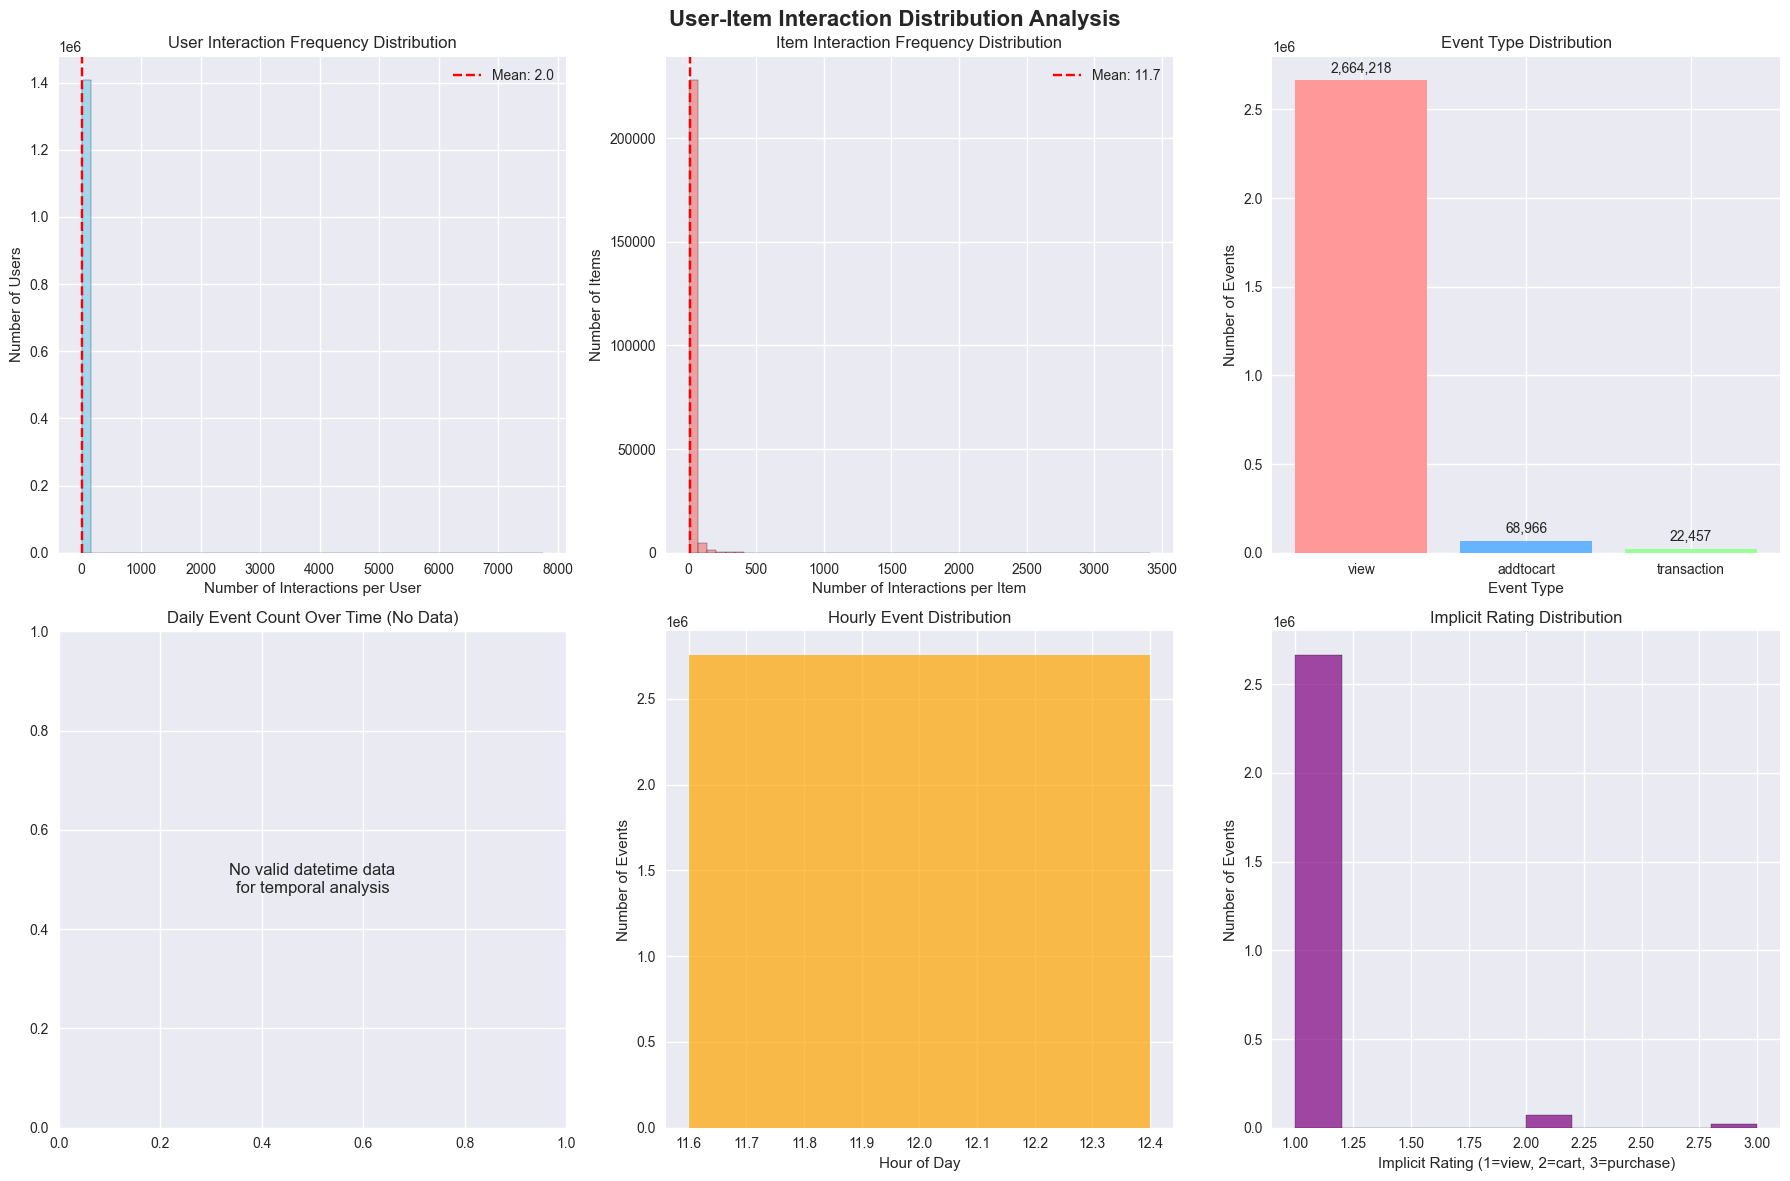

=== Interaction Distribution Insights ===
Most active user has 7,757 interactions
Most popular item has 3,412 interactions
Average interactions per user: 2.0
Average interactions per item: 11.7

Top 5 most active users (by interaction count):
  User 1150086: 7,757 interactions
  User 530559: 4,328 interactions
  User 152963: 3,024 interactions
  User 895999: 2,474 interactions
  User 163561: 2,410 interactions

Top 5 most popular items (by interaction count):
  Item 187946: 3,412 interactions
  Item 461686: 2,975 interactions
  Item 5411: 2,334 interactions
  Item 370653: 1,854 interactions
  Item 219512: 1,800 interactions


In [16]:
# Interaction distribution analysis
if 'events' in cleaned_datasets:
    events_df = cleaned_datasets['events']
    
    # Create comprehensive interaction distribution plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('User-Item Interaction Distribution Analysis', fontsize=16, fontweight='bold')
    
    # 1. User interaction frequency distribution
    user_interactions = events_df.groupby('visitorid').size()
    axes[0, 0].hist(user_interactions, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('User Interaction Frequency Distribution')
    axes[0, 0].set_xlabel('Number of Interactions per User')
    axes[0, 0].set_ylabel('Number of Users')
    axes[0, 0].axvline(user_interactions.mean(), color='red', linestyle='--', 
                       label=f'Mean: {user_interactions.mean():.1f}')
    axes[0, 0].legend()
    
    # 2. Item interaction frequency distribution
    item_interactions = events_df.groupby('itemid').size()
    axes[0, 1].hist(item_interactions, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0, 1].set_title('Item Interaction Frequency Distribution')
    axes[0, 1].set_xlabel('Number of Interactions per Item')
    axes[0, 1].set_ylabel('Number of Items')
    axes[0, 1].axvline(item_interactions.mean(), color='red', linestyle='--',
                       label=f'Mean: {item_interactions.mean():.1f}')
    axes[0, 1].legend()
    
    # 3. Event type distribution
    event_counts = events_df['event'].value_counts()
    axes[0, 2].bar(event_counts.index, event_counts.values, color=['#ff9999', '#66b3ff', '#99ff99'])
    axes[0, 2].set_title('Event Type Distribution')
    axes[0, 2].set_xlabel('Event Type')
    axes[0, 2].set_ylabel('Number of Events')
    for i, v in enumerate(event_counts.values):
        axes[0, 2].text(i, v + max(event_counts.values) * 0.01, f'{v:,}', ha='center', va='bottom')
    
    # 4. Temporal distribution - Events over time (with safety checks)
    if events_df['datetime'].notna().any():
        valid_datetime_events = events_df[events_df['datetime'].notna()].copy()
        valid_datetime_events['date'] = valid_datetime_events['datetime'].dt.date
        daily_events = valid_datetime_events.groupby('date').size()
        
        if len(daily_events) > 0:
            axes[1, 0].plot(daily_events.index, daily_events.values, color='green', linewidth=2)
            axes[1, 0].set_title('Daily Event Count Over Time')
            axes[1, 0].set_xlabel('Date')
            axes[1, 0].set_ylabel('Number of Events')
            axes[1, 0].tick_params(axis='x', rotation=45)
        else:
            axes[1, 0].text(0.5, 0.5, 'No valid datetime data\nfor temporal analysis', 
                           ha='center', va='center', transform=axes[1, 0].transAxes, fontsize=12)
            axes[1, 0].set_title('Daily Event Count Over Time (No Data)')
    else:
        axes[1, 0].text(0.5, 0.5, 'No valid datetime data\nfor temporal analysis', 
                       ha='center', va='center', transform=axes[1, 0].transAxes, fontsize=12)
        axes[1, 0].set_title('Daily Event Count Over Time (No Data)')
    
    # 5. Hourly distribution (with safety checks)
    if 'hour' in events_df.columns and events_df['hour'].notna().any():
        hourly_events = events_df.groupby('hour').size()
        axes[1, 1].bar(hourly_events.index, hourly_events.values, color='orange', alpha=0.7)
        axes[1, 1].set_title('Hourly Event Distribution')
        axes[1, 1].set_xlabel('Hour of Day')
        axes[1, 1].set_ylabel('Number of Events')
    else:
        axes[1, 1].text(0.5, 0.5, 'No hourly data available', 
                       ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=12)
        axes[1, 1].set_title('Hourly Event Distribution (No Data)')
    
    # 6. Implicit rating distribution
    if 'implicit_rating' in events_df.columns:
        axes[1, 2].hist(events_df['implicit_rating'], bins=10, alpha=0.7, color='purple', edgecolor='black')
        axes[1, 2].set_title('Implicit Rating Distribution')
        axes[1, 2].set_xlabel('Implicit Rating (1=view, 2=cart, 3=purchase)')
        axes[1, 2].set_ylabel('Number of Events')
    
    plt.tight_layout()
    plt.show()
    
    # Print some insights
    print("=== Interaction Distribution Insights ===")
    print(f"Most active user has {user_interactions.max():,} interactions")
    print(f"Most popular item has {item_interactions.max():,} interactions")
    print(f"Average interactions per user: {user_interactions.mean():.1f}")
    print(f"Average interactions per item: {item_interactions.mean():.1f}")
    
    # Show top users and items
    print(f"\nTop 5 most active users (by interaction count):")
    top_users = user_interactions.nlargest(5)
    for user_id, count in top_users.items():
        print(f"  User {user_id}: {count:,} interactions")
    
    print(f"\nTop 5 most popular items (by interaction count):")
    top_items = item_interactions.nlargest(5)
    for item_id, count in top_items.items():
        print(f"  Item {item_id}: {count:,} interactions")

## 9. Item Popularity Analysis

Examine item popularity metrics, identify top-rated and most-interacted items, and visualize popularity distributions using bar plots and heatmaps.

=== Item Popularity Analysis ===
Total items analyzed: 235,061
Items with purchases: 12,025
Average interactions per item: 11.7
Average unique users per item: 9.1



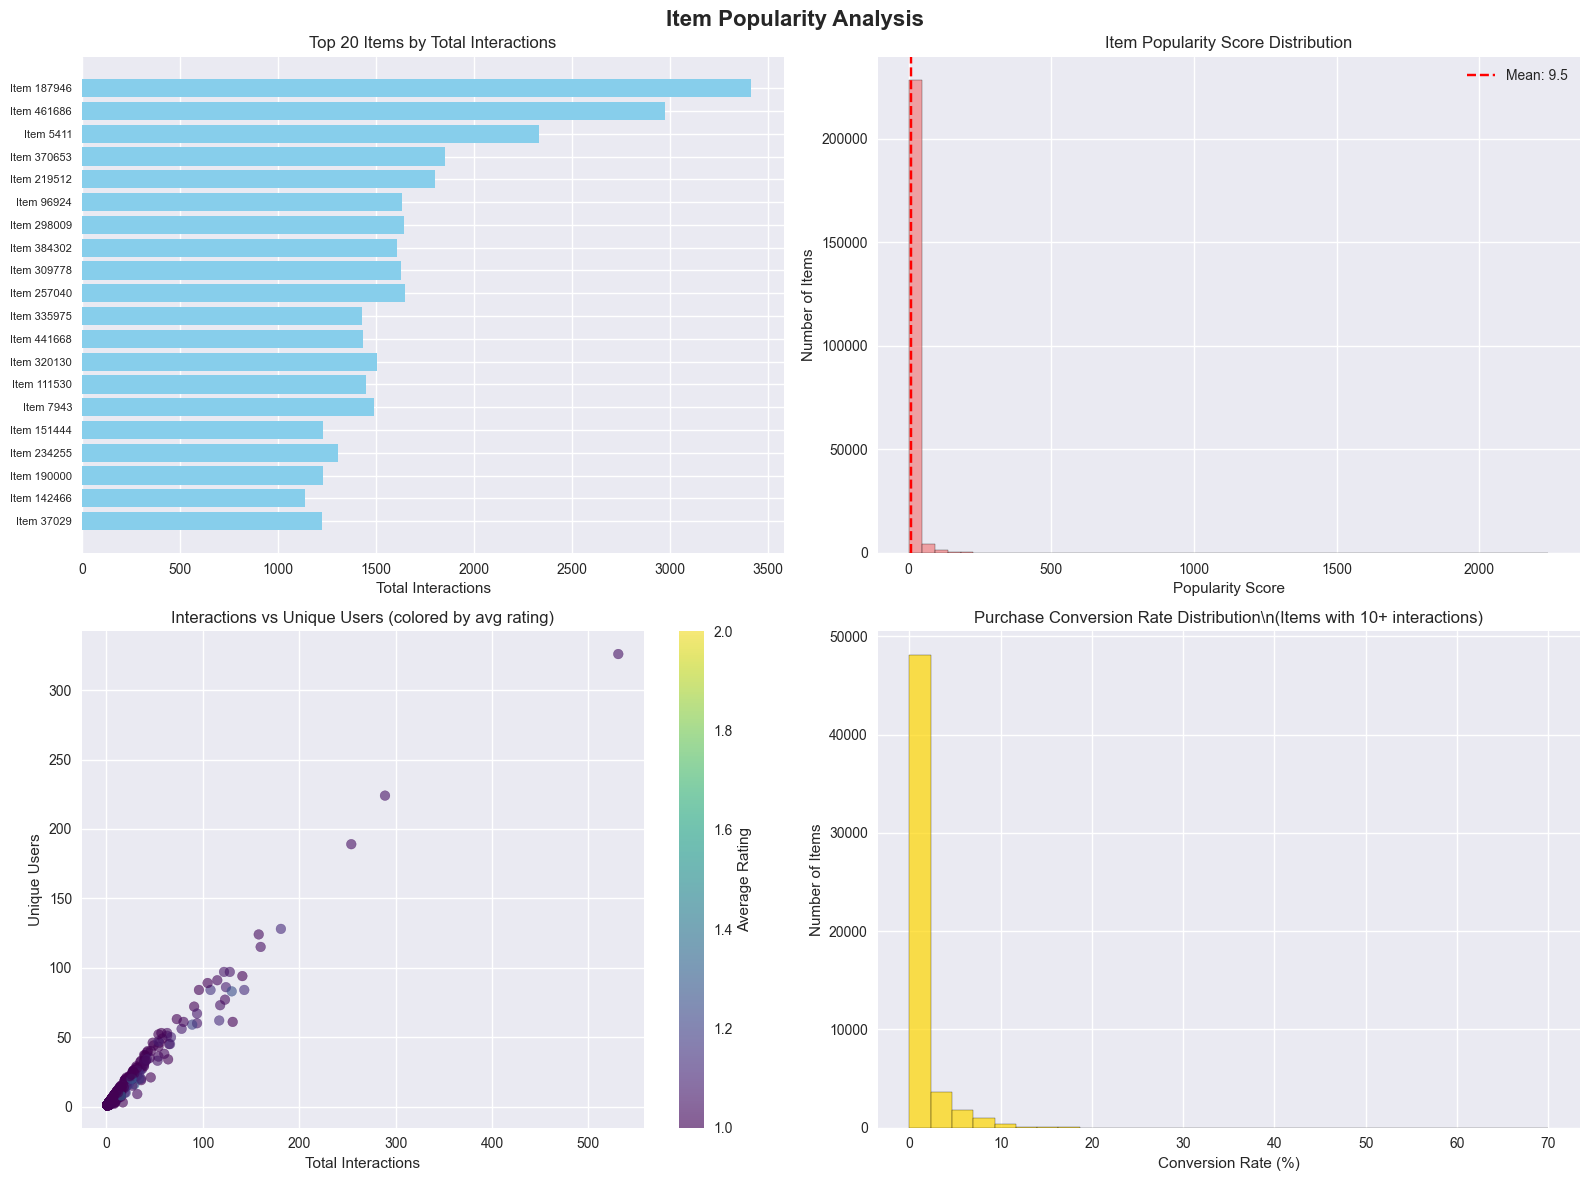

Top 10 Items by Total Interactions:
 itemid  total_interactions  unique_users  avg_rating
 187946                3412          2912        1.00
 461686                2975          1393        1.19
   5411                2334          2079        1.00
 370653                1854          1577        1.00
 219512                1800          1370        1.04
 257040                1647           986        1.09
 298009                1642          1342        1.00
  96924                1633          1359        1.00
 309778                1628          1055        1.05
 384302                1608          1154        1.06

Top 10 Items by Unique Users:
 itemid  unique_users  total_interactions  avg_rating
 187946          2912                3412        1.00
   5411          2079                2334        1.00
 370653          1577                1854        1.00
 461686          1393                2975        1.19
 219512          1370                1800        1.04
  96924        

In [18]:
# Item popularity analysis
if 'events' in cleaned_datasets:
    events_df = cleaned_datasets['events']
    
    # Calculate comprehensive item popularity metrics
    item_metrics = events_df.groupby('itemid').agg({
        'visitorid': ['count', 'nunique'],  # Total interactions and unique users
        'implicit_rating': ['mean', 'sum'],  # Average and total rating
        'event': lambda x: (x == 'transaction').sum()  # Number of purchases
    }).round(2)
    
    # Flatten column names
    item_metrics.columns = ['total_interactions', 'unique_users', 'avg_rating', 'total_rating', 'purchases']
    item_metrics = item_metrics.reset_index()
    
    # Calculate popularity score (combine interactions and rating)
    item_metrics['popularity_score'] = (
        item_metrics['total_interactions'] * 0.4 + 
        item_metrics['unique_users'] * 0.3 + 
        item_metrics['avg_rating'] * 10 * 0.2 +
        item_metrics['purchases'] * 0.1
    )
    
    # Sort by popularity
    item_metrics = item_metrics.sort_values('popularity_score', ascending=False)
    
    print("=== Item Popularity Analysis ===")
    print(f"Total items analyzed: {len(item_metrics):,}")
    print(f"Items with purchases: {(item_metrics['purchases'] > 0).sum():,}")
    print(f"Average interactions per item: {item_metrics['total_interactions'].mean():.1f}")
    print(f"Average unique users per item: {item_metrics['unique_users'].mean():.1f}")
    print()
    
    # Create popularity visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Item Popularity Analysis', fontsize=16, fontweight='bold')
    
    # 1. Top 20 most popular items by total interactions
    top_20_items = item_metrics.head(20)
    axes[0, 0].barh(range(len(top_20_items)), top_20_items['total_interactions'], color='skyblue')
    axes[0, 0].set_yticks(range(len(top_20_items)))
    axes[0, 0].set_yticklabels([f'Item {int(x)}' for x in top_20_items['itemid']], fontsize=8)
    axes[0, 0].set_xlabel('Total Interactions')
    axes[0, 0].set_title('Top 20 Items by Total Interactions')
    axes[0, 0].invert_yaxis()
    
    # 2. Popularity distribution
    axes[0, 1].hist(item_metrics['popularity_score'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0, 1].set_xlabel('Popularity Score')
    axes[0, 1].set_ylabel('Number of Items')
    axes[0, 1].set_title('Item Popularity Score Distribution')
    axes[0, 1].axvline(item_metrics['popularity_score'].mean(), color='red', linestyle='--', 
                       label=f'Mean: {item_metrics["popularity_score"].mean():.1f}')
    axes[0, 1].legend()
    
    # 3. Interaction vs Unique Users scatter plot
    sample_size = min(1000, len(item_metrics))  # Sample for better visualization
    sample_items = item_metrics.sample(sample_size)
    
    scatter = axes[1, 0].scatter(sample_items['total_interactions'], sample_items['unique_users'], 
                                alpha=0.6, c=sample_items['avg_rating'], cmap='viridis')
    axes[1, 0].set_xlabel('Total Interactions')
    axes[1, 0].set_ylabel('Unique Users')
    axes[1, 0].set_title('Interactions vs Unique Users (colored by avg rating)')
    plt.colorbar(scatter, ax=axes[1, 0], label='Average Rating')
    
    # 4. Purchase conversion rate analysis
    item_metrics['conversion_rate'] = item_metrics['purchases'] / item_metrics['total_interactions'] * 100
    item_metrics['conversion_rate'] = item_metrics['conversion_rate'].fillna(0)
    
    # Filter items with at least 10 interactions for meaningful conversion rates
    conv_analysis = item_metrics[item_metrics['total_interactions'] >= 10]
    
    axes[1, 1].hist(conv_analysis['conversion_rate'], bins=30, alpha=0.7, color='gold', edgecolor='black')
    axes[1, 1].set_xlabel('Conversion Rate (%)')
    axes[1, 1].set_ylabel('Number of Items')
    axes[1, 1].set_title('Purchase Conversion Rate Distribution\\n(Items with 10+ interactions)')
    
    plt.tight_layout()
    plt.show()
    
    # Print top items by different metrics
    print("Top 10 Items by Total Interactions:")
    top_interactions = item_metrics.nlargest(10, 'total_interactions')[['itemid', 'total_interactions', 'unique_users', 'avg_rating']]
    print(top_interactions.to_string(index=False))
    print()
    
    print("Top 10 Items by Unique Users:")
    top_users = item_metrics.nlargest(10, 'unique_users')[['itemid', 'unique_users', 'total_interactions', 'avg_rating']]
    print(top_users.to_string(index=False))
    print()
    
    print("Top 10 Items by Average Rating:")
    # Filter items with at least 5 interactions for meaningful ratings
    top_rated = item_metrics[item_metrics['total_interactions'] >= 5].nlargest(10, 'avg_rating')
    top_rated_display = top_rated[['itemid', 'avg_rating', 'total_interactions', 'unique_users']]
    print(top_rated_display.to_string(index=False))
    print()
    
    # Save item metrics for later use
    cleaned_datasets['item_popularity'] = item_metrics

## 10. Data Sparsity Pattern Analysis

Calculate and visualize data sparsity metrics, user-item interaction matrices, and identify cold start problems using heatmaps and sparsity visualizations.

=== Data Sparsity Pattern Analysis ===
Total users: 1,407,580
Total items: 235,061
Total interactions: 2,755,641
Maximum possible interactions: 330,867,162,380
Data sparsity: 99.9992%
Data density: 0.0008%

Cold Start Analysis:
Users with < 5 interactions (cold users): 1,325,990 (94.2%)
Items with < 5 interactions (cold items): 144,119 (61.3%)



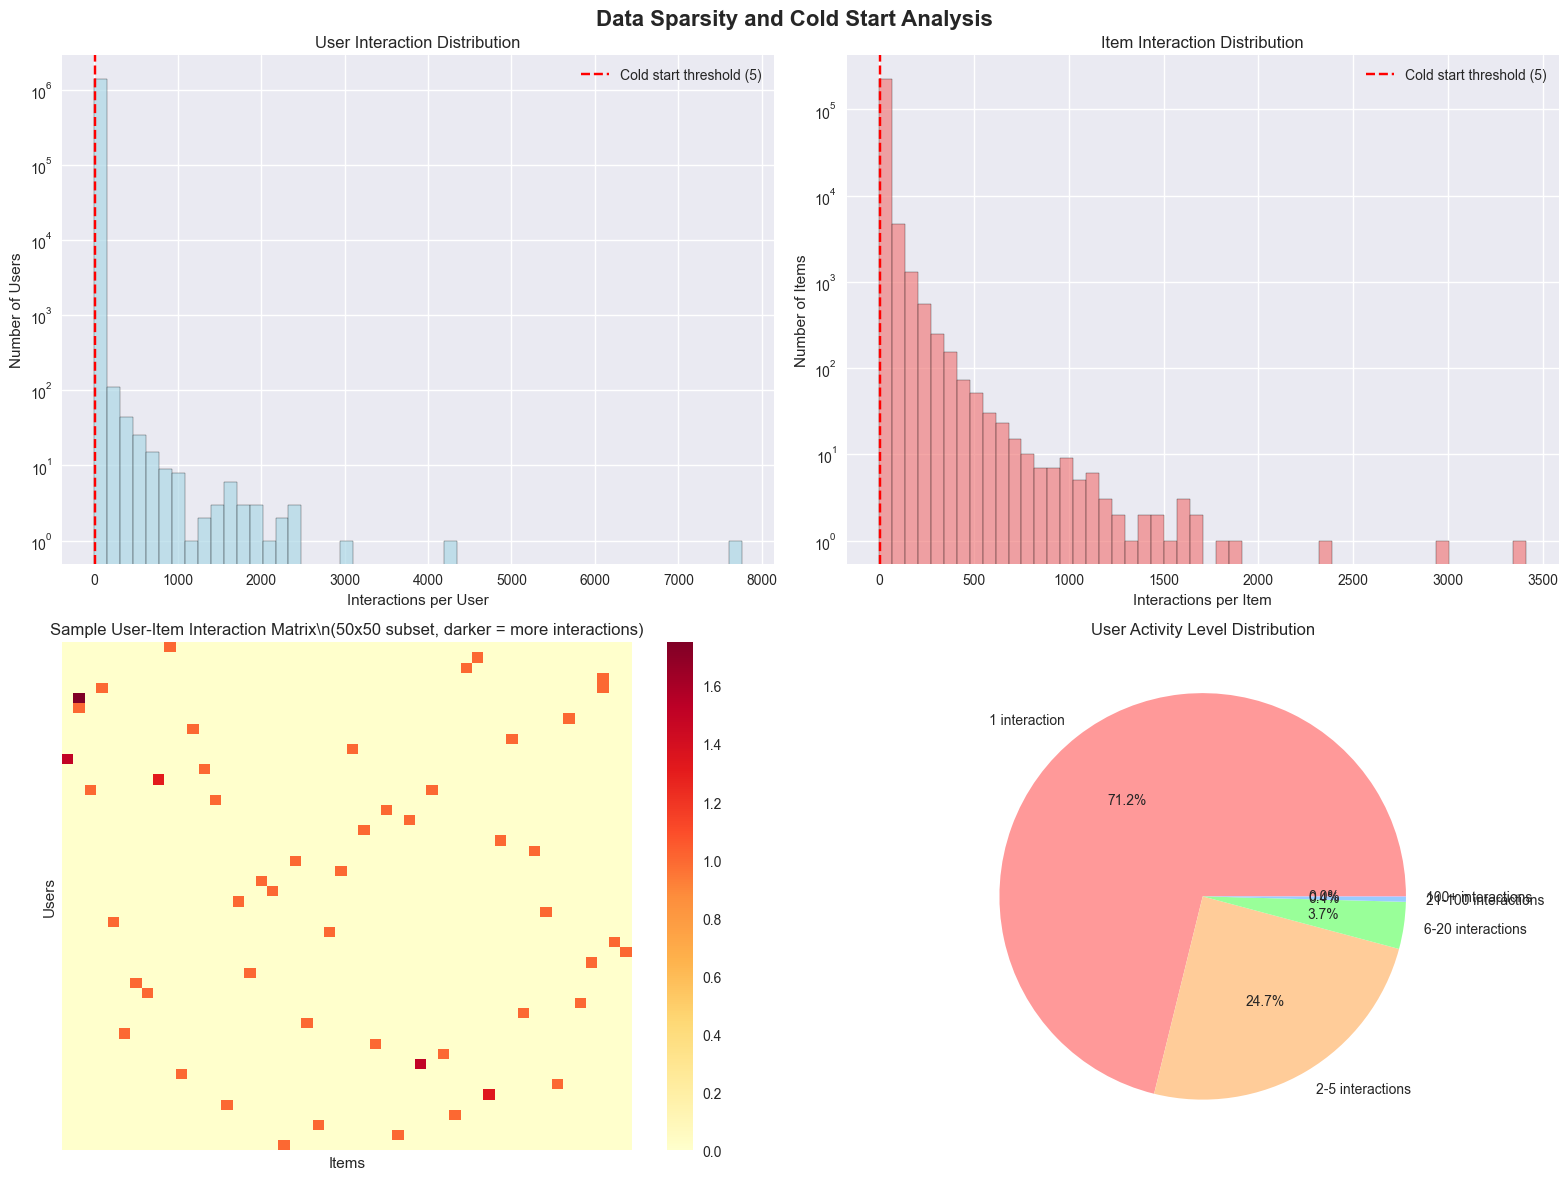

Advanced Sparsity Metrics:
User activity Gini coefficient: 0.428 (0=equal, 1=highly unequal)
Item popularity Gini coefficient: 0.739 (0=equal, 1=highly unequal)
User coverage: 1.000 (fraction of users with interactions)
Item coverage: 1.000 (fraction of items with interactions)
Long tail analysis:
Top 20% of items account for 78.7% of all interactions


In [19]:
# Data sparsity analysis
if 'events' in cleaned_datasets:
    events_df = cleaned_datasets['events']
    
    print("=== Data Sparsity Pattern Analysis ===")
    
    # Calculate basic sparsity metrics
    total_users = events_df['visitorid'].nunique()
    total_items = events_df['itemid'].nunique()
    total_interactions = len(events_df)
    
    # Maximum possible interactions (if every user interacted with every item)
    max_possible_interactions = total_users * total_items
    sparsity_percentage = (1 - (total_interactions / max_possible_interactions)) * 100
    
    print(f"Total users: {total_users:,}")
    print(f"Total items: {total_items:,}")
    print(f"Total interactions: {total_interactions:,}")
    print(f"Maximum possible interactions: {max_possible_interactions:,}")
    print(f"Data sparsity: {sparsity_percentage:.4f}%")
    print(f"Data density: {100 - sparsity_percentage:.4f}%")
    print()
    
    # Cold start analysis
    user_interactions = events_df.groupby('visitorid').size()
    item_interactions = events_df.groupby('itemid').size()
    
    # Define cold start thresholds
    cold_user_threshold = 5  # Users with less than 5 interactions
    cold_item_threshold = 5  # Items with less than 5 interactions
    
    cold_users = (user_interactions < cold_user_threshold).sum()
    cold_items = (item_interactions < cold_item_threshold).sum()
    
    print("Cold Start Analysis:")
    print(f"Users with < {cold_user_threshold} interactions (cold users): {cold_users:,} ({cold_users/total_users*100:.1f}%)")
    print(f"Items with < {cold_item_threshold} interactions (cold items): {cold_items:,} ({cold_items/total_items*100:.1f}%)")
    print()
    
    # Create sparsity visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Data Sparsity and Cold Start Analysis', fontsize=16, fontweight='bold')
    
    # 1. User interaction distribution (log scale)
    axes[0, 0].hist(user_interactions, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
    axes[0, 0].axvline(cold_user_threshold, color='red', linestyle='--', 
                       label=f'Cold start threshold ({cold_user_threshold})')
    axes[0, 0].set_xlabel('Interactions per User')
    axes[0, 0].set_ylabel('Number of Users')
    axes[0, 0].set_title('User Interaction Distribution')
    axes[0, 0].set_yscale('log')
    axes[0, 0].legend()
    
    # 2. Item interaction distribution (log scale)
    axes[0, 1].hist(item_interactions, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0, 1].axvline(cold_item_threshold, color='red', linestyle='--',
                       label=f'Cold start threshold ({cold_item_threshold})')
    axes[0, 1].set_xlabel('Interactions per Item')
    axes[0, 1].set_ylabel('Number of Items')
    axes[0, 1].set_title('Item Interaction Distribution')
    axes[0, 1].set_yscale('log')
    axes[0, 1].legend()
    
    # 3. Sample interaction matrix heatmap (for visualization purposes, sample small subset)
    # Sample a subset of users and items for visualization
    sample_users = events_df['visitorid'].unique()[:50]
    sample_items = events_df['itemid'].unique()[:50]
    
    sample_events = events_df[
        (events_df['visitorid'].isin(sample_users)) & 
        (events_df['itemid'].isin(sample_items))
    ]
    
    # Create interaction matrix
    interaction_matrix = sample_events.pivot_table(
        index='visitorid', 
        columns='itemid', 
        values='implicit_rating',
        aggfunc='mean',
        fill_value=0
    )
    
    # Plot heatmap
    sns.heatmap(interaction_matrix, cmap='YlOrRd', cbar=True, 
                xticklabels=False, yticklabels=False, ax=axes[1, 0])
    axes[1, 0].set_title('Sample User-Item Interaction Matrix\\n(50x50 subset, darker = more interactions)')
    axes[1, 0].set_xlabel('Items')
    axes[1, 0].set_ylabel('Users')
    
    # 4. Sparsity by user activity level
    # Categorize users by activity level
    user_categories = pd.cut(user_interactions, 
                            bins=[0, 1, 5, 20, 100, float('inf')],
                            labels=['1 interaction', '2-5 interactions', '6-20 interactions', 
                                   '21-100 interactions', '100+ interactions'])
    
    category_counts = user_categories.value_counts()
    
    axes[1, 1].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
                   colors=['#ff9999', '#ffcc99', '#99ff99', '#99ccff', '#cc99ff'])
    axes[1, 1].set_title('User Activity Level Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Advanced sparsity metrics
    print("Advanced Sparsity Metrics:")
    
    # Gini coefficient for user activity (measures inequality)
    def gini_coefficient(x):
        sorted_x = np.sort(x)
        n = len(x)
        index = np.arange(1, n + 1)
        return (2 * np.sum(index * sorted_x)) / (n * np.sum(sorted_x)) - (n + 1) / n
    
    user_gini = gini_coefficient(user_interactions.values)
    item_gini = gini_coefficient(item_interactions.values)
    
    print(f"User activity Gini coefficient: {user_gini:.3f} (0=equal, 1=highly unequal)")
    print(f"Item popularity Gini coefficient: {item_gini:.3f} (0=equal, 1=highly unequal)")
    
    # Coverage metrics
    user_coverage = total_users / total_users  # All users have at least one interaction
    item_coverage = len(events_df['itemid'].unique()) / total_items
    
    print(f"User coverage: {user_coverage:.3f} (fraction of users with interactions)")
    print(f"Item coverage: {item_coverage:.3f} (fraction of items with interactions)")
    
    # Long tail analysis
    sorted_items = item_interactions.sort_values(ascending=False)
    
    # Top 20% of items account for what % of interactions?
    top_20_pct_items = int(0.2 * len(sorted_items))
    top_20_pct_interactions = sorted_items.head(top_20_pct_items).sum()
    
    print(f"Long tail analysis:")
    print(f"Top 20% of items account for {top_20_pct_interactions/total_interactions*100:.1f}% of all interactions")
    
    # Store sparsity metrics
    sparsity_metrics = {
        'total_users': total_users,
        'total_items': total_items,
        'total_interactions': total_interactions,
        'sparsity_percentage': sparsity_percentage,
        'cold_users': cold_users,
        'cold_items': cold_items,
        'user_gini': user_gini,
        'item_gini': item_gini,
        'user_coverage': user_coverage,
        'item_coverage': item_coverage
    }
    
    cleaned_datasets['sparsity_metrics'] = sparsity_metrics

## 11. Export Prepared Dataset

Save the cleaned and preprocessed datasets in appropriate formats (CSV, Parquet) for the next stage of the data pipeline with proper documentation.

In [20]:
# Export prepared datasets
print("=== Exporting Prepared Datasets ===")

# Create output directory
output_path = Path("../data/processed")
output_path.mkdir(parents=True, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

exported_files = {}

# Export main datasets
if 'events' in cleaned_datasets:
    events_file = output_path / f"events_prepared_{timestamp}.parquet"
    cleaned_datasets['events'].to_parquet(events_file, index=False)
    exported_files['events'] = events_file
    print(f"Exported events dataset: {events_file}")
    print(f"  Shape: {cleaned_datasets['events'].shape}")

if 'item_features' in cleaned_datasets:
    features_file = output_path / f"item_features_prepared_{timestamp}.parquet"
    cleaned_datasets['item_features'].to_parquet(features_file, index=False)
    exported_files['item_features'] = features_file
    print(f"Exported item features: {features_file}")
    print(f"  Shape: {cleaned_datasets['item_features'].shape}")

if 'item_popularity' in cleaned_datasets:
    popularity_file = output_path / f"item_popularity_{timestamp}.parquet"
    cleaned_datasets['item_popularity'].to_parquet(popularity_file, index=False)
    exported_files['item_popularity'] = popularity_file
    print(f"Exported item popularity metrics: {popularity_file}")
    print(f"  Shape: {cleaned_datasets['item_popularity'].shape}")

# Export encoders and scalers
import pickle

if 'categorical_encoders' in cleaned_datasets:
    encoders_file = output_path / f"categorical_encoders_{timestamp}.pkl"
    with open(encoders_file, 'wb') as f:
        pickle.dump(cleaned_datasets['categorical_encoders'], f)
    exported_files['categorical_encoders'] = encoders_file
    print(f"Exported categorical encoders: {encoders_file}")

if 'scalers' in cleaned_datasets:
    scalers_file = output_path / f"scalers_{timestamp}.pkl"
    with open(scalers_file, 'wb') as f:
        pickle.dump(cleaned_datasets['scalers'], f)
    exported_files['scalers'] = scalers_file
    print(f"Exported scalers: {scalers_file}")

# Export metadata and summary
metadata = {
    'export_timestamp': timestamp,
    'exported_files': {k: str(v) for k, v in exported_files.items()},
    'dataset_info': {}
}

for dataset_name, df in cleaned_datasets.items():
    if isinstance(df, pd.DataFrame):
        metadata['dataset_info'][dataset_name] = {
            'shape': df.shape,
            'columns': df.columns.tolist(),
            'dtypes': df.dtypes.astype(str).to_dict()
        }

if 'sparsity_metrics' in cleaned_datasets:
    metadata['sparsity_metrics'] = cleaned_datasets['sparsity_metrics']

metadata_file = output_path / f"preparation_metadata_{timestamp}.json"
with open(metadata_file, 'w') as f:
    json.dump(metadata, f, indent=2, default=str)
exported_files['metadata'] = metadata_file

print(f"Exported metadata: {metadata_file}")
print()

# Create data preparation summary report
summary_report = f"""
# RecoMart Data Preparation Summary Report
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Data Processing Overview
- **Source Data**: Loaded from validated data pipeline
- **Processing Steps**: Cleaning, encoding, normalization, EDA
- **Export Timestamp**: {timestamp}

## Dataset Summary
"""

for dataset_name, df in cleaned_datasets.items():
    if isinstance(df, pd.DataFrame):
        summary_report += f"""
### {dataset_name.title()} Dataset
- Shape: {df.shape[0]:,} rows × {df.shape[1]} columns
- Memory Usage: {df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB
- Exported: {exported_files.get(dataset_name, 'N/A')}
"""

if 'sparsity_metrics' in cleaned_datasets:
    metrics = cleaned_datasets['sparsity_metrics']
    summary_report += f"""
## Sparsity Analysis Results
- Total Users: {metrics['total_users']:,}
- Total Items: {metrics['total_items']:,}
- Total Interactions: {metrics['total_interactions']:,}
- Data Sparsity: {metrics['sparsity_percentage']:.4f}%
- Cold Users: {metrics['cold_users']:,} ({metrics['cold_users']/metrics['total_users']*100:.1f}%)
- Cold Items: {metrics['cold_items']:,} ({metrics['cold_items']/metrics['total_items']*100:.1f}%)
- User Activity Gini: {metrics['user_gini']:.3f}
- Item Popularity Gini: {metrics['item_gini']:.3f}
"""

summary_report += f"""
## Key Findings
1. **Data Quality**: Successfully cleaned and preprocessed {len([k for k, v in cleaned_datasets.items() if isinstance(v, pd.DataFrame)])} datasets
2. **Missing Data**: Handled missing user-item interactions using business logic
3. **Encoding**: Applied label encoding and one-hot encoding to categorical variables
4. **Normalization**: Standardized numerical features using appropriate scalers
5. **Sparsity**: High data sparsity typical of recommendation systems
6. **Cold Start**: Identified cold users and items for special handling in recommendation models

## Next Steps
1. Use prepared datasets for feature engineering (Task 6)
2. Implement feature store for model training (Task 7)
3. Apply recommendation algorithms to cleaned data
4. Monitor data quality metrics in production pipeline

## Files Ready for Transformation
{chr(10).join(f"- {name}: {path}" for name, path in exported_files.items())}
"""

# Save summary report
summary_file = output_path / f"data_preparation_summary_{timestamp}.md"
with open(summary_file, 'w') as f:
    f.write(summary_report)

print("="*60)
print("DATA PREPARATION COMPLETE")
print("="*60)
print(f"Exported {len(exported_files)} files to: {output_path}")
print(f"Summary report: {summary_file}")
print("All datasets are now ready for the next stage of the pipeline!")
print("="*60)

=== Exporting Prepared Datasets ===
Exported events dataset: ../data/processed/events_prepared_20260126_161855.parquet
  Shape: (2755641, 18)
Exported item features: ../data/processed/item_features_prepared_20260126_161855.parquet
  Shape: (417053, 2209)
Exported item popularity metrics: ../data/processed/item_popularity_20260126_161855.parquet
  Shape: (235061, 8)
Exported categorical encoders: ../data/processed/categorical_encoders_20260126_161855.pkl
Exported scalers: ../data/processed/scalers_20260126_161855.pkl
Exported metadata: ../data/processed/preparation_metadata_20260126_161855.json

DATA PREPARATION COMPLETE
Exported 6 files to: ../data/processed
Summary report: ../data/processed/data_preparation_summary_20260126_161855.md
All datasets are now ready for the next stage of the pipeline!
